# **Preprocessing of the Caltech-101 Dataset**

The [Caltech-101](https://data.caltech.edu/records/mzrjq-6wc02) dataset contains RGB images of objects belonging to 101 categories, with each class having between 31 and 800 images. Additionally, the dataset includes annotations that provide the coordinates of the bounding boxes for each object in its respective image, as well as the contour coordinates of the objects, which in this notebook are transformed for simple image segmentation tasks. While the dataset can be downloaded using TensorFlow Datasets, this option only includes the images and their respective labels. For this reason, in this notebook, the dataset is manually downloaded from its official website, allowing access to the images, labels, bounding boxes, and masks, which are then stored in TFRecord format for efficient use with TensorFlow during model training or fine-tuning in Computer Vision tasks.

## **Imports**

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import cv2
from scipy.io import loadmat
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from google.colab import drive
import json
import os

drive.mount("/content/drive")

## **Parameters**

In [ ]:
test_split = 0.2
SEED = 123
url_data = "https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1"
data_filename = "/content/drive/MyDrive/Datasets/caltech101"
os.makedirs(data_filename, exist_ok=True)

## **Download and Extract the Dataset**

In [ ]:
path_data = tf.keras.utils.get_file(origin=url_data, cache_subdir="/content", extract=True)
path_data = path_data.split(".")[0]
path_data

137414764/137414764 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


'/content/caltech-101'

In [ ]:
!ls $path_data

101_ObjectCategories.tar.gz  Annotations.tar  show_annotation.m


In [ ]:
!tar -xzf /content/caltech-101/101_ObjectCategories.tar.gz -C $path_data
!tar -xf /content/caltech-101/Annotations.tar -C $path_data

## **Preprocess the Dataset**

In [ ]:
images_dir_path = os.path.join(path_data, "101_ObjectCategories")
notes_dir_path = os.path.join(path_data, "Annotations")

In [ ]:
# Rename some folders within 'Annotations' to match the corresponding image folders
dic_rename = {
    "Airplanes_Side_2": "airplanes",
    "Faces_2": "Faces",
    "Faces_3": "Faces_easy",
    "Motorbikes_16": "Motorbikes"
}

for name1, name2 in dic_rename.items():
  os.rename(os.path.join(notes_dir_path, name1), os.path.join(notes_dir_path, name2))

In [ ]:
# Create a DataFrame with the image paths, annotations, and corresponding class names

# Exclude the 'BACKGROUND_Google' class, as it is not relevant
class_names = [folder for folder in os.listdir(images_dir_path) if folder != "BACKGROUND_Google"]

list_df = []

for name in class_names:
  path_images = os.path.join(images_dir_path, name)
  path_notes = os.path.join(notes_dir_path, name)

  images = sorted([os.path.join(path_images, image) for image in os.listdir(path_images)])
  notes = sorted([os.path.join(path_notes, note) for note in os.listdir(path_notes)])

  df = pd.DataFrame({"image": images, "note": notes})
  df["name"] = name.capitalize().replace("_", " ")
  list_df.append(df)

df_data = pd.concat(list_df).reset_index(drop=True)
df_data = df_data.sample(frac=1, random_state=SEED)

In [ ]:
# Find the class names
class_names = df_data.name.sort_values().unique().tolist()
print(len(class_names))
print(class_names)

101
['Accordion', 'Airplanes', 'Anchor', 'Ant', 'Barrel', 'Bass', 'Beaver', 'Binocular', 'Bonsai', 'Brain', 'Brontosaurus', 'Buddha', 'Butterfly', 'Camera', 'Cannon', 'Car side', 'Ceiling fan', 'Cellphone', 'Chair', 'Chandelier', 'Cougar body', 'Cougar face', 'Crab', 'Crayfish', 'Crocodile', 'Crocodile head', 'Cup', 'Dalmatian', 'Dollar bill', 'Dolphin', 'Dragonfly', 'Electric guitar', 'Elephant', 'Emu', 'Euphonium', 'Ewer', 'Faces', 'Faces easy', 'Ferry', 'Flamingo', 'Flamingo head', 'Garfield', 'Gerenuk', 'Gramophone', 'Grand piano', 'Hawksbill', 'Headphone', 'Hedgehog', 'Helicopter', 'Ibis', 'Inline skate', 'Joshua tree', 'Kangaroo', 'Ketch', 'Lamp', 'Laptop', 'Leopards', 'Llama', 'Lobster', 'Lotus', 'Mandolin', 'Mayfly', 'Menorah', 'Metronome', 'Minaret', 'Motorbikes', 'Nautilus', 'Octopus', 'Okapi', 'Pagoda', 'Panda', 'Pigeon', 'Pizza', 'Platypus', 'Pyramid', 'Revolver', 'Rhino', 'Rooster', 'Saxophone', 'Schooner', 'Scissors', 'Scorpion', 'Sea horse', 'Snoopy', 'Soccer ball', 'Sta

In [ ]:
# Add the labels to the DataFrame
df_data["label"] = df_data.name.apply(lambda x: class_names.index(x))
df_data

,image,note,name,label
2131,/content/caltech-101/101_ObjectCategories/Face...,/content/caltech-101/Annotations/Faces_easy/an...,Faces easy,37
6444,/content/caltech-101/101_ObjectCategories/emu/...,/content/caltech-101/Annotations/emu/annotatio...,Emu,33
5758,/content/caltech-101/101_ObjectCategories/gran...,/content/caltech-101/Annotations/grand_piano/a...,Grand piano,44
8656,/content/caltech-101/101_ObjectCategories/stra...,/content/caltech-101/Annotations/strawberry/an...,Strawberry,89
209,/content/caltech-101/101_ObjectCategories/star...,/content/caltech-101/Annotations/starfish/anno...,Starfish,86
...,...,...,...,...
7382,/content/caltech-101/101_ObjectCategories/Moto...,/content/caltech-101/Annotations/Motorbikes/an...,Motorbikes,65
7763,/content/caltech-101/101_ObjectCategories/Face...,/content/caltech-101/Annotations/Faces/annotat...,Faces,36
5218,/content/caltech-101/101_ObjectCategories/kang...,/content/caltech-101/Annotations/kangaroo/anno...,Kangaroo,52
1346,/content/caltech-101/101_ObjectCategories/wind...,/content/caltech-101/Annotations/windsor_chair...,Windsor chair,98


In [ ]:
# There are no null values
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8677 entries, 2131 to 3582
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   8677 non-null   object
 1   note    8677 non-null   object
 2   name    8677 non-null   object
 3   label   8677 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 338.9+ KB


It is noted that the dataset is imbalanced, with the number of images per class ranging from 31 to 800. Therefore, it will be split into 80% for training and 20% for testing, taking into account the ``label`` column to preserve the class distribution in both sets.

In [ ]:
df_data.name.value_counts().sort_values()

,count
name,
Inline skate,31
Metronome,32
Binocular,33
Garfield,34
Gerenuk,34
...,...
Watch,239
Faces,435
Faces easy,435


In [ ]:
# Split the DataFrame into training and testing sets
df_train, df_test = train_test_split(df_data, test_size=test_split, random_state=SEED, stratify=df_data.label)

del df_data
len(df_train), len(df_test)

(6941, 1736)

It can be observed that the proportions of the distributions in both the training and testing DataFrames are maintained:

In [ ]:
df_train.name.value_counts().sort_values()

,count
name,
Inline skate,25
Binocular,26
Metronome,26
Wild cat,27
Garfield,27
...,...
Watch,191
Faces,348
Faces easy,348


In [ ]:
df_test.name.value_counts().sort_values()

,count
name,
Inline skate,6
Metronome,6
Binocular,7
Wild cat,7
Octopus,7
...,...
Watch,48
Faces easy,87
Faces,87


In [ ]:
# Function for preprocessing the images and annotations

def preprocessing(row, encode=True, return_contour=False):
  # Decode the images and convert them to NumPy arrays
  image = tf.keras.utils.load_img(row["image"])
  image = np.array(image)

  # Load the annotations
  note = row["note"]
  note = loadmat(note)

  # Obtain the coordinates of the bounding boxes
  box = note["box_coord"][0]
  box = box[[0, 2, 1, 3]]

  # Convert the contour coordinates to segmentation masks
  ymin, xmin, ymax, xmax = tuple(box)
  contour = note["obj_contour"]
  contour = np.array([contour[0] + xmin, contour[1] + ymin])

  mask = np.zeros(image.shape[:-1])
  cv2.fillPoly(mask, [contour.T.astype(np.int32)], color=1)
  mask = mask[..., None].astype(np.uint8)

  # Normalize the box coordinates to the range [0;1]
  ymin, ymax = ymin/image.shape[0], ymax/image.shape[0]
  xmin, xmax = xmin/image.shape[1], xmax/image.shape[1]
  box = np.array([ymin, xmin, ymax, xmax])

  # Encode the images and masks if necessary
  if encode:
    image = tf.image.encode_jpeg(tf.convert_to_tensor(image, dtype=tf.uint8)).numpy()
    mask = tf.image.encode_png(tf.convert_to_tensor(mask, dtype=tf.uint8)).numpy()

  if return_contour:
    return image, box, mask, contour
  else:
    return image, box, mask

**Example**

In [ ]:
id = 0
example = df_train.iloc[id]

In [ ]:
image, box, mask, contour = preprocessing(example, encode=False, return_contour=True)
image.shape, box.shape, mask.shape, contour.shape

((269, 300, 3), (4,), (269, 300, 1), (2, 29))

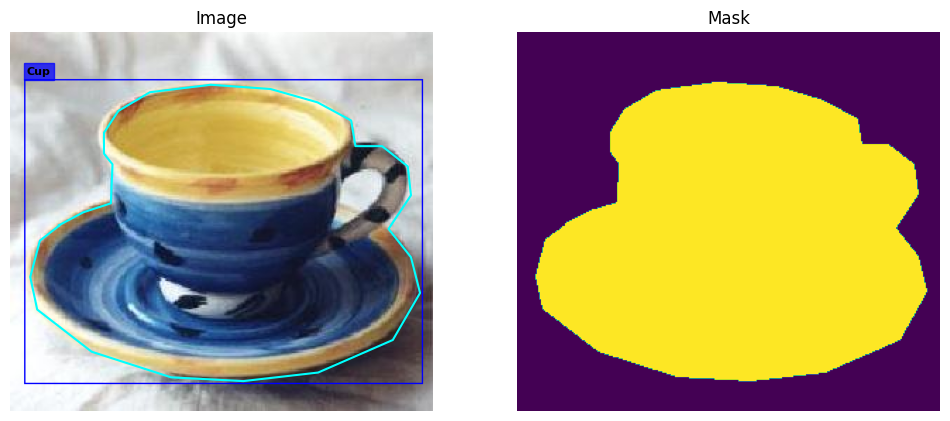

In [ ]:
ymin, xmin, ymax, xmax = tuple(box)
ymin, ymax = int(ymin*image.shape[0]), int(ymax*image.shape[0])
xmin, xmax = int(xmin*image.shape[1]), int(xmax*image.shape[1])
cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 0, 255), 1)

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.plot(contour[0], contour[1], color="cyan", linewidth=1.5)
plt.text(
    x=xmin+(image.shape[1]*0.005), y=ymin-(image.shape[0]*0.01), s=example["name"],
    color="black", fontsize=8, fontweight="bold", ha="left", va="bottom",
    bbox={"boxstyle":"square", "facecolor": "blue", "edgecolor":"blue", "alpha":0.75}
)
plt.title("Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title("Mask")
plt.axis("off")

plt.show()

In [ ]:
# Function to save the components of a DataFrame in TFRecord format
def save_tfrecord(filename, df):
  with tf.io.TFRecordWriter(filename) as writer:
    for _, row in tqdm(df.iterrows()):
      image, box, mask = preprocessing(row)
      label = row["label"]

      features = {
          "image": tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),
          "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
          "box": tf.train.Feature(float_list=tf.train.FloatList(value=box)),
          "mask": tf.train.Feature(bytes_list=tf.train.BytesList(value=[mask]))
      }

      features = tf.train.Features(feature=features)
      example = tf.train.Example(features=features).SerializeToString()
      writer.write(example)

In [ ]:
train_filename = os.path.join(data_filename, "train.tfrecord")
test_filename = os.path.join(data_filename, "test.tfrecord")

In [ ]:
# Save the training and testing datasets
save_tfrecord(train_filename, df_train)
save_tfrecord(test_filename, df_test)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
# Save the dataset metadata
path_metadata = os.path.join(data_filename, "metadata.json")

with open(path_metadata, "w") as f:
  metadata = {
      "size": {
          "train": len(df_train),
          "test": len(df_test)
      },
      "class_names": class_names
  }

  json.dump(metadata, f)

## **Examples of use in Computer Vision tasks**

In [ ]:
@tf.function
def decode_tfrecord(sample, task="object_detection"):
  features = {
      "image": tf.io.FixedLenFeature((), tf.string),
      "label": tf.io.FixedLenFeature((), tf.int64),
      "box": tf.io.FixedLenFeature((4, ), tf.float32),
      "mask": tf.io.FixedLenFeature((), tf.string),
  }

  parsed_features = tf.io.parse_example(sample, features)
  image = tf.io.decode_jpeg(parsed_features["image"], channels=3)

  if task == "object_detection":
    label = parsed_features["label"]
    box = parsed_features["box"]
    return image, (label, box)

  elif task == "semantic_segmentation":
    mask = tf.io.decode_png(parsed_features["mask"], channels=1)
    return image, mask

  else:
    raise ValueError(f"Unrecognized task: '{task}'. Valid tasks are 'object_detection' or 'semantic_segmentation'.")

In [ ]:
def load_dataset(filename, size, task):
  dataset = tf.data.TFRecordDataset(filename)
  dataset = dataset.map(lambda x: decode_tfrecord(x, task), num_parallel_calls=tf.data.AUTOTUNE)
  dataset = dataset.apply(tf.data.experimental.assert_cardinality(size))
  return dataset

In [ ]:
with open(path_metadata, "r") as f:
  metadata = json.load(f)

train_size = metadata["size"]["train"]
test_size = metadata["size"]["test"]
class_names = metadata["class_names"]

print(train_size, test_size, len(class_names))
print(class_names)

6941 1736 101
['Accordion', 'Airplanes', 'Anchor', 'Ant', 'Barrel', 'Bass', 'Beaver', 'Binocular', 'Bonsai', 'Brain', 'Brontosaurus', 'Buddha', 'Butterfly', 'Camera', 'Cannon', 'Car side', 'Ceiling fan', 'Cellphone', 'Chair', 'Chandelier', 'Cougar body', 'Cougar face', 'Crab', 'Crayfish', 'Crocodile', 'Crocodile head', 'Cup', 'Dalmatian', 'Dollar bill', 'Dolphin', 'Dragonfly', 'Electric guitar', 'Elephant', 'Emu', 'Euphonium', 'Ewer', 'Faces', 'Faces easy', 'Ferry', 'Flamingo', 'Flamingo head', 'Garfield', 'Gerenuk', 'Gramophone', 'Grand piano', 'Hawksbill', 'Headphone', 'Hedgehog', 'Helicopter', 'Ibis', 'Inline skate', 'Joshua tree', 'Kangaroo', 'Ketch', 'Lamp', 'Laptop', 'Leopards', 'Llama', 'Lobster', 'Lotus', 'Mandolin', 'Mayfly', 'Menorah', 'Metronome', 'Minaret', 'Motorbikes', 'Nautilus', 'Octopus', 'Okapi', 'Pagoda', 'Panda', 'Pigeon', 'Pizza', 'Platypus', 'Pyramid', 'Revolver', 'Rhino', 'Rooster', 'Saxophone', 'Schooner', 'Scissors', 'Scorpion', 'Sea horse', 'Snoopy', 'Soccer b

In [ ]:
train_dataset = load_dataset(train_filename, size=train_size, task="object_detection")
test_dataset = load_dataset(test_filename, size=test_size, task="semantic_segmentation")

### **Object Detection**

(269, 300, 3)
tf.Tensor(26, shape=(), dtype=int64)
tf.Tensor([0.12639405 0.03333334 0.92565054 0.97333336], shape=(4,), dtype=float32) 



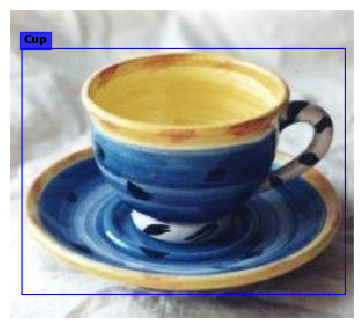

In [ ]:
for image, (label, box) in train_dataset.take(1):
  print(image.shape)
  print(label)
  print(box, "\n")


image = image.numpy()
ymin, xmin, ymax, xmax = tuple(box.numpy())
ymin, ymax = int(ymin*image.shape[0]), int(ymax*image.shape[0])
xmin, xmax = int(xmin*image.shape[1]), int(xmax*image.shape[1])
cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 0, 255), 1)

plt.figure(figsize=(6, 4))
plt.imshow(image)
plt.text(
    x=xmin+(image.shape[1]*0.005), y=ymin-(image.shape[0]*0.01), s=class_names[label],
    color="black", fontsize=8, fontweight="bold", ha="left", va="bottom",
    bbox={"boxstyle":"square", "facecolor": "blue", "edgecolor":"blue", "alpha":0.75}
)

plt.axis("off");

### **Imagen Segmentation**

(179, 269, 3)
(179, 269, 1) 



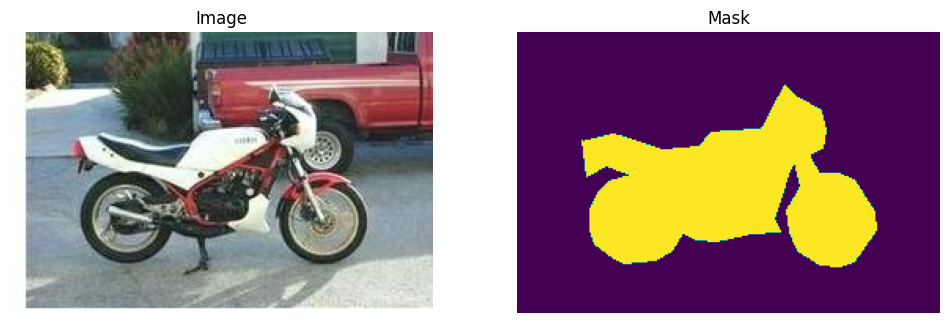

In [ ]:
for image, mask in test_dataset.take(1):
  print(image.shape)
  print(mask.shape, "\n")


plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title(f"Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title("Mask")

plt.axis("off");